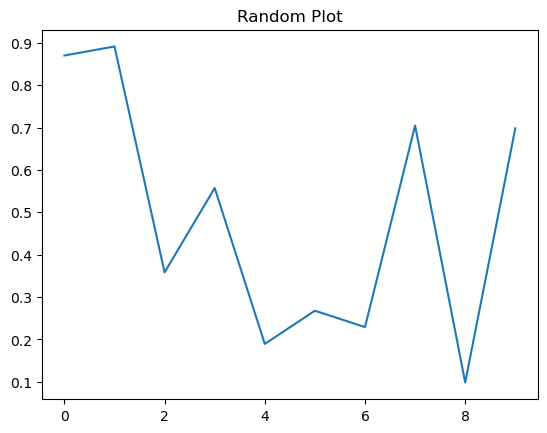

Personne 0 évacuée au pas de temps 12
Personne 5 évacuée au pas de temps 18
Personne 1 évacuée au pas de temps 21


In [ ]:


import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simple plot to check if it works
plt.plot(np.random.rand(10))
plt.title("Random Plot")
plt.show()

def sortiePlusProche(pos, sorties):
    distances = np.linalg.norm(sorties - pos, axis=1)
    indice_sortie = np.argmin(distances)
    return sorties[indice_sortie], distances[indice_sortie]


def direction(pos, sorties):
    sortie, _ = sortiePlusProche(pos, sorties)
    d = np.array((sortie - pos)).reshape(-1)
    norm = np.linalg.norm(d)
    return d / norm if norm != 0 else 0



def step(pos,sorties,v,dt): 
    dir = direction(pos,sorties)
    return v*dt*np.atleast_1d(dir)

def generer_people(nb, x_max, y_max):
    people = np.empty((nb,6), dtype=object)
    for i in range(nb):
        x = random.randint(0, x_max)
        y = random.randint(0, y_max)
        niveau_perception = random.choice(['faible', 'élevé'])
        if niveau_perception == 'faible':
            vitesse = np.round(random.uniform(0.8, 1.4), 1)
        else:
            vitesse = np.round(random.uniform(1.5, 2.0), 1)
        sortie = False
        people[i, 0] = i
        people[i, 1] = x
        people[i, 2] = y
        people[i, 3] = niveau_perception
        people[i, 4] = vitesse
        people[i, 5] = sortie
    return people

def step_people(people, sorties, largeur_sortie, dt, t_max, temps_attente_sortie):
    temps = np.arange(0, t_max, dt)
    n_step = len(temps)  # Nombre de pas
    res = np.empty((n_step, len(people), 6), dtype=object)
    res[0] = people

    for i in range(n_step - 1):
        for j in range(len(people)):
            if res[i, j, 5]:  # Si la personne est déjà sortie, on passe à la personne suivante
                continue

            pos = np.array((res[i, j, 1], res[i, j, 2]))  # Position actuelle de la personne
            v = res[i, j, 4]  # Vitesse individuelle de la personne j

            # Calculer la nouvelle vitesse en fonction des interactions avec d'autres personnes
            v_new = v
            for k in range(len(people)):
                if j != k:  # Ne pas comparer avec la même personne
                    pos_k = np.array((res[i, k, 1], res[i, k, 2]))  # Position de la personne k
                    dist = np.linalg.norm(pos - pos_k)  # Distance entre les personnes j et k

                    # Si les personnes sont trop proches, ajuster la vitesse
                    if dist < 1.5:  # Distance de sécurité arbitraire
                        v_new *= 0.8  # Réduire la vitesse
                    elif dist < 3.0:  # Distance à laquelle la vitesse commence à être influencée
                        v_new *= 0.9  # Réduire légèrement la vitesse

            # Calculer le nouveau déplacement avec la vitesse ajustée
            new_step = step(pos, sorties, v_new, dt)
            new_pos = pos + new_step

            # Vérifier si la personne est à proximité d'une sortie
            for sortie in sorties:
                distance_sortie = np.linalg.norm(new_pos - sortie)
                marge_sortie = v_new * dt * 0.5
                if distance_sortie < marge_sortie and abs(pos[1] - sortie[1]) < largeur_sortie / 2:
                    res[i + 1:, j, 5] = True  # Mettre à jour la colonne "sortie"
                    res[i + 1:, j, 1] = new_pos[0]
                    res[i + 1:, j, 2] = new_pos[1]
                    res[i + 1:, j, 0] = res[i, j, 0]  # Numéro d'identification inchangé
                    res[i + 1:, j, 3] = res[i, j, 3]  # Niveau de perception inchangé
                    res[i + 1:, j, 4] = res[i, j, 4]  # Vitesse inchangée
                    break  # Sortir de la boucle une fois qu'une sortie est trouvée

            # Si la personne n'est pas à proximité d'une sortie, mettre à jour sa position normalement
            else:
                res[i + 1, j, 1] = new_pos[0]  # Nouvelle position x
                res[i + 1, j, 2] = new_pos[1]  # Nouvelle position y
                res[i + 1, j, 0] = res[i, j, 0]  # Numéro d'identification inchangé
                res[i + 1, j, 3] = res[i, j, 3]  # Niveau de perception inchangé
                res[i + 1, j, 4] = v_new  # Nouvelle vitesse ajustée
                res[i + 1, j, 5] = res[i, j, 5]  # Sortie inchangée

            # Attendre un certain temps avant de se déplacer à nouveau
            if temps_attente_sortie > 0:
                temps_attente_sortie -= 1

    return res



def evacuation(liste_step, sorties, largeur_sortie, temps_attente_sortie):
    evacuated = set()  # Utiliser un ensemble pour stocker les personnes évacuées pour une recherche plus efficace
    waiting_time = 0  # Temps d'attente avant que deux autres personnes sortent

    # Définir la liste de personnes évacuées
    evacuated_people = []

    while len(evacuated) < len(liste_step[0]):  # Continuer l'évacuation jusqu'à ce que toutes les personnes soient évacuées
        for step_idx, step in enumerate(liste_step):
            if len(evacuated) == len(liste_step[0]):  # Si toutes les personnes ont été évacuées, arrêter
                break
            for person in step:
                if person[0] in evacuated:  # Vérifier si la personne a déjà été évacuée
                    continue
                pos = np.array([person[1], person[2]])
                for sortie in sorties:
                    direction_sortie = sortie - pos
                    distance_sortie = np.linalg.norm(direction_sortie)
                    if person[5] and distance_sortie < largeur_sortie / 2 and direction_sortie[1] > 0:
                        print(f"Personne {person[0]} évacuée au pas de temps {step_idx}")
                        evacuated.add(person[0])
                        evacuated_people.append(person)  # Ajouter la personne évacuée à la liste
                        break

            # Attendre un certain temps avant de permettre à deux autres personnes de sortir
            if len(evacuated) >= 2 and waiting_time < temps_attente_sortie:
                waiting_time += 1
                continue

            # Permettre à deux autres personnes de sortir après le temps d'attente
            if waiting_time == temps_attente_sortie:
                count = 0  # Compteur pour suivre le nombre de personnes sorties à chaque pas de temps
                for other_person in evacuated_people:
                    if count >= 2:  # Sortir uniquement deux personnes à la fois
                        break
                    if other_person[0] not in evacuated:
                        pos = np.array([other_person[1], other_person[2]])
                        for sortie in sorties:
                            direction_sortie = sortie - pos
                            distance_sortie = np.linalg.norm(direction_sortie)
                            if distance_sortie < largeur_sortie / 2 and direction_sortie[1] > 0:
                                print(f"Personne {other_person[0]} évacuée au pas de temps {step_idx}")
                                evacuated.add(other_person[0])
                                count += 1
                waiting_time += 1
                continue

    # Retirer les personnes évacuées de la simulation à partir du moment où elles sont évacuées
    people = []
    for step in liste_step:
        people.extend([person for person in step if person[0] not in evacuated])

    if len(people) == 0:
        print("Tous les individus sont évacués")
    else:
        print("Nombre d'individus évacués:", len(evacuated_people), "\nNombre d'individus restants à évacuer:", len(people))

    return evacuated_people, people

x1 = 30
y1 = 50
pos1 = np.array((x1,y1))

x2 = 15
y2 = 60
pos2 = np.array((x2,y2))

sx1 = 0
sy1 = 0
sx2 = 30
sy2 = 0
sx3 = 60
sy3 = 25
sortie1 = np.array((sx1,sy1))
sortie2 = np.array((sx2,sy2))
sortie3 = np.array((sx3,sy3))
sorties = np.array((sortie1,sortie2,sortie3))

v = 1.5
nb_pers = 10
x_max = 60
y_max = 60
dt = 1
tmax = 60
temps_attente_sortie = 1   
   
people = generer_people(nb_pers, x_max, y_max)

liste_step = step_people(people, sorties, 1, dt, tmax, temps_attente_sortie)

evacuated = evacuation(liste_step, sorties, 1, temps_attente_sortie)

def plot_xy(liste_step, sorties):
    plt.figure(figsize=(8, 8))  # Définir la taille de la figure

    for step_idx, step in enumerate(liste_step):
        for person in step:
            pos_x = person[1]
            pos_y = person[2]
            plt.plot(pos_x, pos_y, 'bo')  # Trace la position de chaque personne
            plt.text(pos_x, pos_y, f"{person[0]}", fontsize=8)  # Ajouter le numéro de la personne

    plt.plot(sorties[:, 0], sorties[:, 1], "ro")  # Trace les positions des sorties en rouge
    for i, sortie in enumerate(sorties):
        plt.text(sortie[0], sortie[1], f"Sortie {i+1}", fontsize=8)  # Ajouter le numéro de la sortie

    margin = 5  # Marge ajoutée aux limites du tracé
    plt.xlim(-margin, x_max + margin)  # Définir les limites x du tracé avec marge
    plt.ylim(-margin, y_max + margin)  # Définir les limites y du tracé avec marge

    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Étapes de la simulation ({len(liste_step)} pas de temps)")
    plt.grid(True)
    plt.show()




In [ ]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

def sortiePlusProche(pos, sorties):
    distances = np.linalg.norm(sorties - pos, axis=1)
    indice_sortie = np.argmin(distances)
    return sorties[indice_sortie], distances[indice_sortie]

def direction(pos, sorties):
    sortie, _ = sortiePlusProche(pos, sorties)
    direction_vector = sortie - pos
    norm = np.linalg.norm(direction_vector)
    return direction_vector / norm if norm != 0 else np.zeros_like(pos)

def step(pos, sorties, v, dt):
    dir_vector = direction(pos, sorties)
    return v * dt * dir_vector

def generer_people(nb, x_max, y_max):
    people = np.zeros((nb, 6))
    for i in range(nb):
        x, y = random.randint(0, x_max), random.randint(0, y_max)
        niveau_perception = random.choice(['faible', 'élevé'])
        vitesse = np.round(random.uniform(0.8, 2.0), 1) if niveau_perception == 'élevé' else np.round(random.uniform(0.8, 1.4), 1)
        people[i] = [i, x, y, vitesse, 0, 0]
    return people

def step_people(people, sorties, largeur_sortie, dt, t_max):
    temps = np.arange(0, t_max, dt)
    n_step = len(temps)
    positions = np.zeros((n_step, len(people), 2))
    positions[0, :, :2] = people[:, 1:3]
    for t in range(1, n_step):
        for i, person in enumerate(people):
            if person[4] == 1:
                continue
            pos = positions[t - 1, i]
            v = person[3]
            new_pos = pos + step(pos, sorties, v, dt)
            _, dist = sortiePlusProche(new_pos, sorties)
            if dist < largeur_sortie:
                person[4] = 1
            positions[t, i] = new_pos
    return positions

def plot_evacuation(positions, sorties):
    plt.figure(figsize=(10, 10))
    for t, pos in enumerate(positions):
        plt.scatter(pos[:, 0], pos[:, 1], color='blue')
    plt.scatter(sorties[:, 0], sorties[:, 1], color='red', marker='x', s=100)
    plt.title("Trajectory of Evacuation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

# Initialisation
nb_pers = 10
x_max, y_max = 100, 100
sorties = np.array([[0, 0], [50, 50], [100, 100]])
people = generer_people(nb_pers, x_max, y_max)

# Simulation et affichage
positions = step_people(people, sorties, 1, 1, 60)
plot_evacuation(positions, sorties)


In [ ]:
import numpy as np
import random
pip install matplotlib --upgrade
import matplotlib.pyplot as plt


def sortiePlusProche(pos, sorties):
    distances = np.linalg.norm(sorties - pos, axis=1)
    indice_sortie = np.argmin(distances)
    return sorties[indice_sortie], distances[indice_sortie]

def direction(pos, sorties):
    sortie, _ = sortiePlusProche(pos, sorties)
    direction_vector = sortie - pos
    norm = np.linalg.norm(direction_vector)
    return direction_vector / norm if norm != 0 else np.zeros_like(pos)

def step(pos, sorties, v, dt):
    dir_vector = direction(pos, sorties)
    return v * dt * dir_vector

def generer_people(nb, x_max, y_max):
    people = np.zeros((nb, 6))
    for i in range(nb):
        x, y = random.randint(0, x_max), random.randint(0, y_max)
        niveau_perception = random.choice(['faible', 'élevé'])
        vitesse = np.round(random.uniform(1.5, 2.0), 1) if niveau_perception == 'élevé' else np.round(random.uniform(0.8, 1.4), 1)
        people[i] = [i, x, y, vitesse, 0, 0]
    print("Initial people positions:", people[:, 1:3])
    return people

def step_people(people, sorties, largeur_sortie, dt, t_max):
    temps = np.arange(0, t_max, dt)
    n_step = len(temps)
    positions = np.zeros((n_step, len(people), 2))
    positions[0, :, :2] = people[:, 1:3]
    for t in range(1, n_step):
        for i, person in enumerate(people):
            if person[4] == 1:
                continue
            pos = positions[t - 1, i]
            v = person[3]
            new_pos = pos + step(pos, sorties, v, dt)
            _, dist = sortiePlusProche(new_pos, sorties)
            if dist < largeur_sortie:
                person[4] = 1
            positions[t, i] = new_pos
    print("Final positions:", positions[-1])
    return positions

def plot_evacuation(positions, sorties):
    plt.figure(figsize=(10, 10))
    for t, pos in enumerate(positions):
        plt.scatter(pos[:, 0], pos[:, 1], color='blue', label=f'Time {t}' if t == 0 else "")
    plt.scatter(sorties[:, 0], sorties[:, 1], color='red', marker='x', s=100, label='Exits')
    plt.title("Trajectory of Evacuation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

nb_pers = 10
x_max, y_max = 100, 100
sorties = np.array([[0, 0], [50, 50], [100, 100]])
people = generer_people(nb_pers, x_max, y_max)
positions = step_people(people, sorties, 1, 1, 60)
plot_evacuation(positions, sorties)
import matplotlib.pyplot as plt
import numpy as np

# Test de tracé simple
plt.figure()
plt.plot(np.random.rand(10))
plt.title("Random Plot")
plt.show()
